In [18]:
from sklearn.linear_model import LinearRegression
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

In [19]:
# importamos csv guardado en las funciones previas
eda_data = pd.read_csv('../Datasets/data.csv')

## Limpieza y EDA

Obtenemos una lista de información con valores no-nulos de cada columna de nuestro Dataframe

In [20]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29894 entries, 0 to 29893
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      29894 non-null  int64  
 1   publisher       23879 non-null  object 
 2   genres          28660 non-null  object 
 3   app_name        29893 non-null  object 
 4   title           29893 non-null  object 
 5   url             29894 non-null  object 
 6   release_date    29894 non-null  object 
 7   tags            29733 non-null  object 
 8   discount_price  204 non-null    float64
 9   reviews_url     29893 non-null  object 
 10  specs           29225 non-null  object 
 11  price           28818 non-null  object 
 12  early_access    29894 non-null  bool   
 13  id              29893 non-null  float64
 14  developer       28644 non-null  object 
 15  sentiment       23156 non-null  object 
 16  metascore       2553 non-null   float64
 17  modify_date     29894 non-null 

Debido que algunas columnas tienen muy poca información de datos, y otros no tienen relevancia para el modelo que se aplicó, las columnas a utilizar fueron: ['genres', 'early_access', 'sentiment', 'year', 'price']

In [21]:
eda_data = eda_data[['genres', 'early_access', 'sentiment', 'year', 'price']]

### 1. Manejo de datos nulos

Como se aprecia en la siguiente información, la cantidad de datos no-nulos entre cada variable no dista significativamente, por ello se procedió a eliminar los datos nulos en lugar de reemplazarlos por otros valores

In [22]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29894 entries, 0 to 29893
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        28660 non-null  object
 1   early_access  29894 non-null  bool  
 2   sentiment     23156 non-null  object
 3   year          29894 non-null  int64 
 4   price         28818 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 963.5+ KB


In [23]:
# Eliminar filas con valores nulos en las columnas seleccionadas
eda_data.dropna(subset=['genres', 'sentiment', 'price'], inplace=True, ignore_index=True)

### 2. Limpieza de datos columna: 'price'

Dado que los valores como 'Free Demo', 'Install Now', 'Play for Free!', 'Play WARMACHINE: Tactics Demo', 'Free Mod', 'Install Theme', 'Play Now', etc., no proporcionan información sobre el precio real del juego, son eliminados. Sin embargo, los valores 'Free to play', se mantendrán y serán convertidos al valor de 0.

In [24]:
# Devuelve la lista de valores no numéricos de la columna 'price'
values_non_num = eda_data['price'][~eda_data['price'].apply(pd.to_numeric, errors='coerce').notna()].unique().tolist()
print(values_non_num)

['Free To Play', 'Free to Play', 'Free', 'Free Demo', 'Play for Free!', 'Install Now', 'Play WARMACHINE: Tactics Demo', 'Free Mod', 'Install Theme', 'Play Now', 'Free HITMAN™ Holiday Pack', 'Play the Demo', 'Free to Try', 'Free to Use', 'Third-party']


In [25]:
values_to_drop = ['Free Demo', 'Play for Free!', 'Install Now', 'Play WARMACHINE: Tactics Demo', 'Free Mod', 'Install Theme', 'Play Now', 'Free HITMAN™ Holiday Pack', 'Play the Demo', 'Free to Try', 'Free to Use', 'Third-party']

val_dict = {value: np.nan for value in values_to_drop}
eda_data.loc[:, 'price'] = eda_data['price'].replace(val_dict)

In [26]:
values_to_modify = ['Free To Play', 'Free to Play', 'Free']
val_dict_modify = {value: 0 for value in values_to_modify}
eda_data.loc[:, 'price'] = eda_data['price'].replace(val_dict_modify)

In [27]:
# Cambia el tipo de valor en la columna 'price'
eda_data['price'] = pd.to_numeric(eda_data['price'], errors='coerce')
print(eda_data['price'].dtype)

float64


### 3. Limpieza de datos columna 'sentiment'

Al igual que la columna 'price', la columna 'sentiment' posee datos no informativos como ['1 user reviews', '2 user reviews', '3 user reviews',..]. Por ello, se procedió a cambiar esos valores a NaN y, posteriormente, eliminarlos

In [12]:
# Devuelve una lista de valores unicos de la columna 'sentiment'
print(eda_data['sentiment'].unique().tolist())

['Mostly Positive', 'Mixed', '1 user reviews', '3 user reviews', 'Very Positive', 'Overwhelmingly Positive', '6 user reviews', '5 user reviews', '2 user reviews', 'Positive', 'Mostly Negative', 'Very Negative', '9 user reviews', '8 user reviews', 'Negative', '7 user reviews', '4 user reviews', 'Overwhelmingly Negative']


In [29]:
values_non_inf = ['1 user reviews', '3 user reviews', '6 user reviews', '5 user reviews', '2 user reviews', '9 user reviews', '8 user reviews', '7 user reviews', '4 user reviews']
non_info_dict = {value: np.nan for value in values_non_inf}
eda_data.loc[:, 'sentiment'] = eda_data['sentiment'].replace(non_info_dict)

In [30]:
eda_data.dropna(subset=['sentiment', 'price'], ignore_index=True, inplace=True)

In [31]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13654 entries, 0 to 13653
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        13654 non-null  object 
 1   early_access  13654 non-null  bool   
 2   sentiment     13654 non-null  object 
 3   year          13654 non-null  int64  
 4   price         13654 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 440.2+ KB


## Visualización de las caracteristicas de las variables


In [32]:
# Devuelve el resumen estadístico de las columnas numéricas
eda_data.describe()

,year,price
count,13654.000000,13654.000000
mean,2014.150579,10.080921
std,3.877608,14.252053
min,1983.000000,0.000000
25%,2014.000000,2.990000
50%,2015.000000,6.990000
75%,2016.000000,12.990000
max,2021.000000,771.710000


### a) Análisis de la variable 'year'

Debido a la escaza información en años anteriores al 2005, se procedió a descartar años de lanzamiento anteriores a esa fecha.

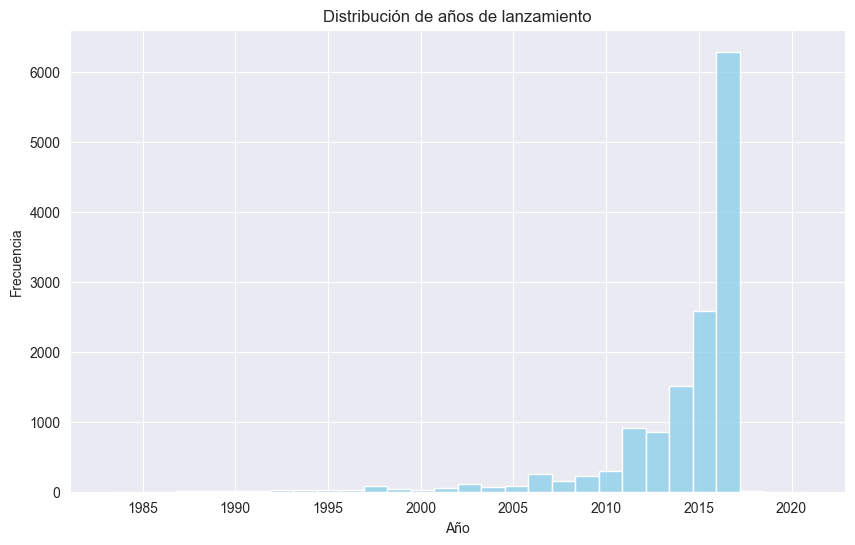

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(eda_data['year'], bins=30, kde=False, color='skyblue')
plt.title('Distribución de años de lanzamiento')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.show()

### b) Análisis de la variable 'price'

En las figuras siguientes, podemos observar outliers significativos en el segundo gráfico, y una mayor concentración de frecuencia de precios en el rango de [0 y 55] en el primero. Por lo tanto, se eliminaron los precios mayores a 55.


In [ ]:
# Elimina los datos anteriores al 2005
eda_data = eda_data[eda_data['year'] >= 2005]

#### b.1) Gráfico de barras para rangos de precios

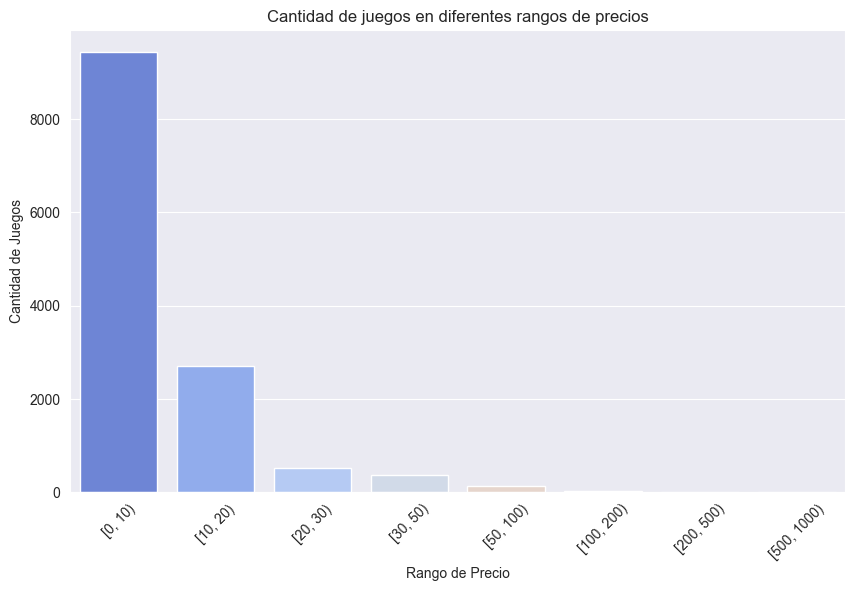

In [37]:
price_ranges = pd.cut(eda_data['price'], bins=[0, 10, 20, 30, 50, 100, 200, 500, 1000], right=False)
plt.figure(figsize=(10, 6))
sns.countplot(x=price_ranges, palette='coolwarm')
plt.title('Cantidad de juegos en diferentes rangos de precios')
plt.xlabel('Rango de Precio')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=45)
plt.show()

#### b.2) Boxplot de precios

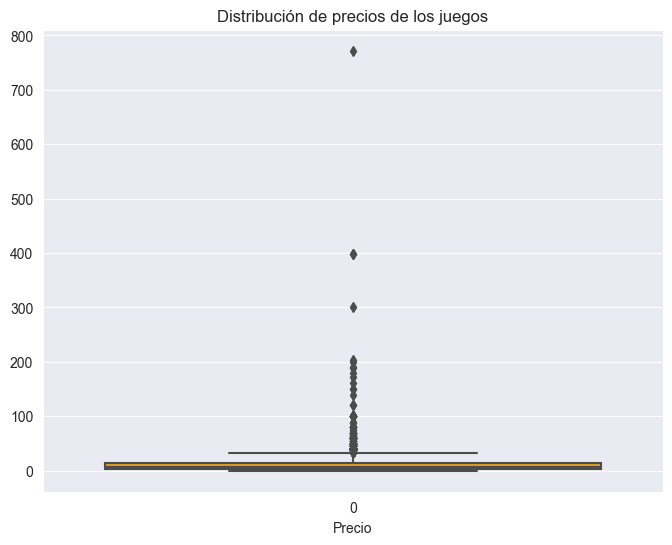

In [38]:
plt.figure(figsize=(8, 6))
sns.boxplot(eda_data['price'], color='orange')
plt.title('Distribución de precios de los juegos')
plt.xlabel('Precio')
plt.show()

In [39]:
# Eliminación de precios mayor a 55
eda_data = eda_data.loc[eda_data['price'] <= 55]

### c) Análisis de la variable 'sentiment'


Como se muestra la tendencia de concentración de datos al lado izquierdo, se procedió ennumerar loa sentimientos en el orden correspondiente al gráfico.
{'Mixed': 0, 'Very Positive': 1, 'Positive': 2, 'Mostly Positive': 3,'Mostly Negative': 4, 'Overwhelmingly Positive': 5, 'Negative': 6, 'Very Negative': 7, 'Overwhelmingly Negative': 8}


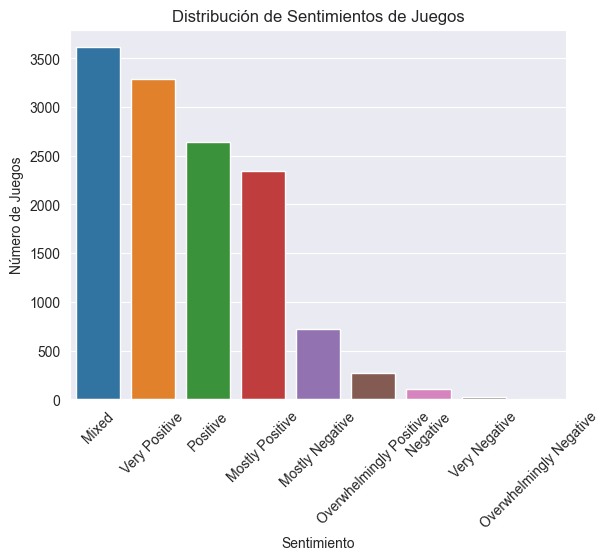

In [41]:
# Gráfico de barras para sentimiento
sns.countplot(x='sentiment', data=eda_data, order=eda_data['sentiment'].value_counts().index)
plt.xticks(rotation=45)
plt.xlabel('Sentimiento')
plt.ylabel('Número de Juegos')
plt.title('Distribución de Sentimientos de Juegos')
plt.show()

### d) Análisis de la variable 'genres'

Debido a la poca información de datos para algunos géneros como se aprecia en el gráfico, se procedió a reducir las opciones de géneros, ya que el modelo podría tener menos eficiencia.

Los géneros a no tomar en cuenta serán: ['Animation &amp; Modeling', 'Video Production', 'Software Training', 'Photo Editing', 'Web Publishing', 'Design &amp; Illustration', 'Accounting', 'Utilities', 'Education', 'Audio Production']

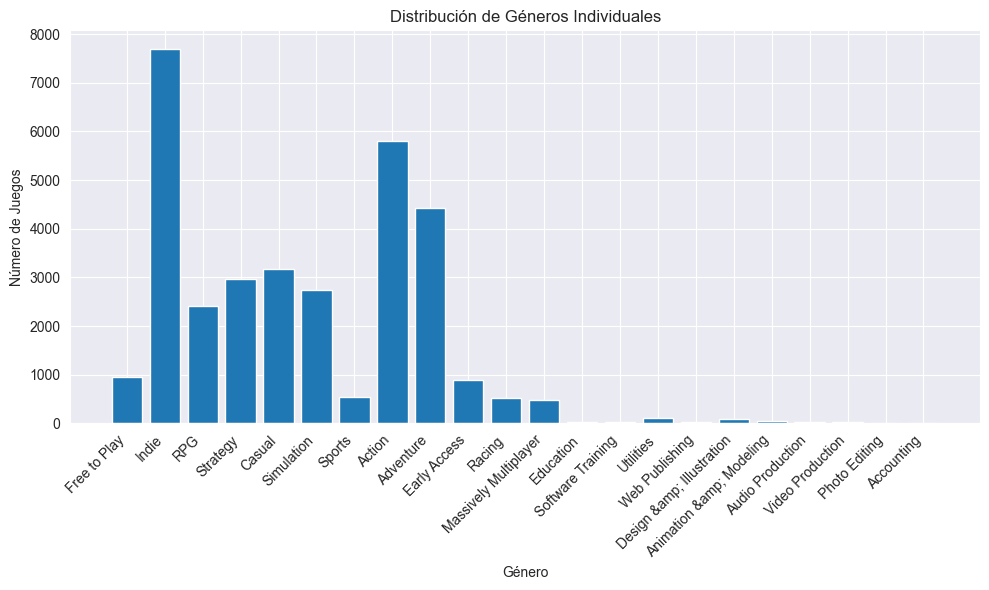

In [43]:
# Convertir las cadenas de géneros en listas reales
eda_data['genres'] = eda_data['genres'].apply(ast.literal_eval)

# Crear una lista plana de todos los géneros en el conjunto de datos
all_genres = [genre for genres_list in eda_data['genres'] for genre in genres_list]

# Contar cuántas veces aparece cada género
genre_counts = Counter(all_genres)

# Crear un gráfico de barras para géneros individuales
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Género')
plt.ylabel('Número de Juegos')
plt.title('Distribución de Géneros Individuales')
plt.tight_layout()
plt.show()


Eliminación de los géneros con poca información

In [52]:
# Lista de géneros inútiles para eliminar
useless_genres = ['Animation &amp; Modeling', 'Video Production', 'Software Training', 'Photo Editing', 'Web Publishing', 'Design &amp; Illustration', 'Accounting', 'Utilities', 'Education', 'Audio Production']

# Función para filtrar los géneros útiles de una lista
def filter_useless_genres(genres_list):
    return [genre for genre in genres_list if genre not in useless_genres]

# Aplicar la función de filtrado a la columna 'genres'
eda_data['genres'] = eda_data['genres'].apply(filter_useless_genres)


In [53]:
# Guardar archivo listo
eda_data.to_csv('../Datasets/data_predict.csv')

## Modelo de Predicción

In [55]:
def predict_price(genre, year, sentiment, early_access):
    # Codificar el género como binario
    eda_data['genre_encoded'] = eda_data['genres'].apply(lambda x: genre in x)

    # Convertir el sentimiento en valores numéricos
    sentiment_mapping = {'Mixed': 0, 'Very Positive': 1, 'Positive': 2, 'Mostly Positive': 3,'Mostly Negative': 4, 'Overwhelmingly Positive': 5, 'Negative': 6, 'Very Negative': 7, 'Overwhelmingly Negative': 8}
    sentiment_numeric = sentiment_mapping[sentiment]

    # Crear la columna 'sentiment_numeric' en eda_data
    eda_data['sentiment_numeric'] = eda_data['sentiment'].apply(lambda x: sentiment_mapping[x])

    # Crear el conjunto de características (X)
    X = eda_data[['genre_encoded', 'year', 'early_access', 'sentiment_numeric']]

    # Crear el conjunto de etiquetas (y)
    y = eda_data['price']

    # Crear y ajustar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)

    # Crear un diccionario con los valores de las características para la predicción
    input_data = {
        'genre_encoded': genre in eda_data['genres'],
        'year': year,
        'early_access': early_access,
        'sentiment_numeric': sentiment_numeric
    }

    # Crear una fila de datos a partir del diccionario
    input_row = pd.DataFrame([input_data])

    # Realizar la predicción
    y_predict = model.predict(input_row)

    # Calcular el RMSE a partir del MSE
    rmse = np.sqrt(np.mean((y_predict - eda_data['price'])**2))

    result = {'price': y_predict[0], 'RMSE': rmse}
    return result

predict_price(genre='Casual', year=2024, sentiment='Mostly Positive', early_access=False)

{'price': 9.57879083352438, 'RMSE': 9.030281605958086}

In [54]:
unique_individual_genres = set()

for genres_list in eda_data['genres']:
    unique_individual_genres.update(genres_list)

unique_individual_genres = list(unique_individual_genres)
print(unique_individual_genres)

['Racing', 'Simulation', 'Early Access', 'Strategy', 'Free to Play', 'Adventure', 'Sports', 'Action', 'Massively Multiplayer', 'RPG', 'Casual', 'Indie']
